# Air BnB Project

This project will be split into four parts. 

- Part 1: Data Acquistion and Cleaning
- Part 2: Data Visualisation and simple time series modeling
- Part 3: ARIMA modeling 
- Part 4: ARMAX model with regularization 

## Part 1: Data Acquistion and Cleaning
The data was all obtained from http://insideairbnb.com/vancouver/. The individual files were scrapped and merged to allow for easier manipulation. The code for this is in a different [notebook](DataAcquisition.ipynb). 

## Part 2: Data Vis and simple time series modeling
### Loading the data 
The listings directory contains multiple .txt files in comman seperated format. The first thing to do is run through this directory, read each file and then write it to a new .txt file. This file with all the combined data will make it easier to work with the data. 

In [42]:
#load relevant packages
library(ggplot2)
library(Amelia)
library(IDPmisc)
library(zoo)
library(xts)
library(stats)
library(forecast)

Warning message:
“package ‘forecast’ was built under R version 3.4.4”

In [2]:
#load data
df <- read.csv('combined_listing.csv',header=TRUE,na.strings=c("","NA"))

#get column names
# colnames(df)

### Distribution of the price data

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

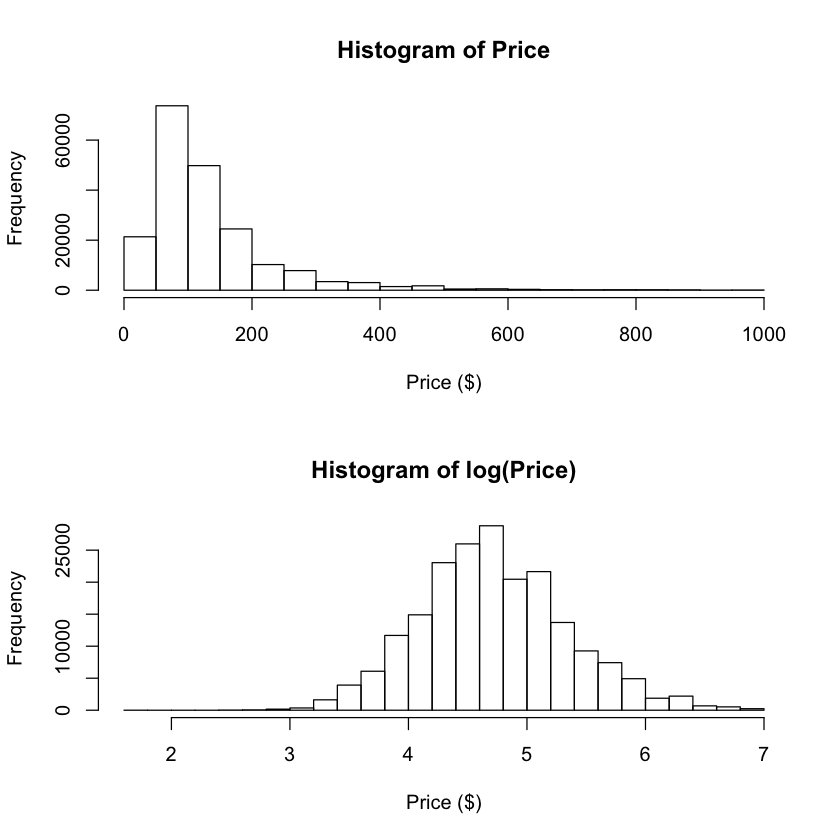

In [3]:
#create a new df to explore price and time data
n <- nrow(df)
price.col <- df[1:n,'price']
price.col = as.numeric(gsub("\\$", "", price.col))
last.review <- as.Date(df[1:n,'last_review'])

#make new dataframe with only price and last review column
ts.df <- data.frame(price.col,last.review)


#oder df by date
ts.df <- ts.df[order(as.Date(ts.df$last.review, format="%Y-%m-%d")),]


par(mfrow=c(2,1))
#histogram of the price data
hist(ts.df$price.col,breaks=20,xlab="Price ($)",main = 'Histogram of Price')

#The above plot shows that the data a strong right skew. Needs to be transformed to be more normal.
ts.df$log.price <- log(ts.df$price.col)
hist(ts.df$log.price,xlab='Price ($)',main='Histogram of log(Price)')

### Time series of the price data

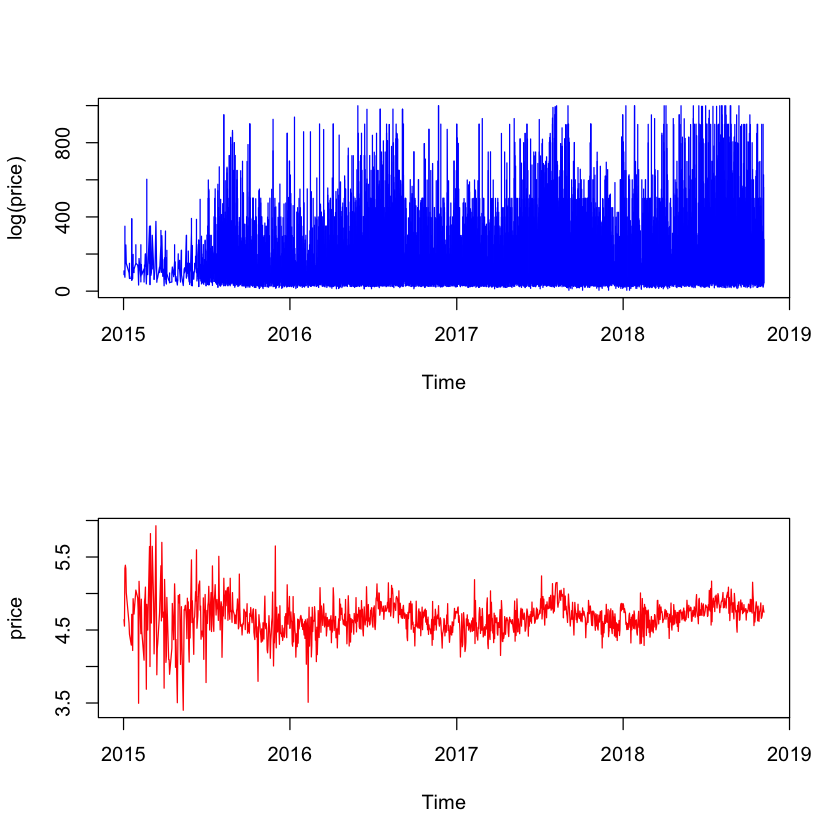

In [4]:
#better col names and clean up df
colnames(ts.df) <- c('price','date','logprice')
ts.df <- NaRV.omit(ts.df)

#get first and last date 
start_date <- ts.df$date[1]
last_date <- ts.df$date[nrow(ts.df)]

#sequence of dates for date column
date <- data.frame(seq(from=start_date,to=last_date,by='days'))
colnames(date) <- c('date')

ts.df <- subset(ts.df, ts.df$date> '2015-01-01')
par(mfrow=c(2,1))
#ts plot of raw prices. May be a little too noisy. Some filtering probably needed
plot(as.Date(ts.df$date),ts.df$price, type='l',ylab='log(price)',xlab='Time',col='blue')

#initial plot too noisy. Group by day
meanprice <-  aggregate(ts.df$logprice,by=list(ts.df$date),mean)
colnames(meanprice) <- c('date','meanprice')
meanprice <- merge(x = date, y = meanprice, by = 'date', all = TRUE)
meanprice$date <- as.Date(meanprice$date)

#remove data from before 2015. Too little of it
meanprice <- na.omit(meanprice[meanprice[['date']] > as.Date('2015-01-01') ,])

meanprice <- data.frame(meanprice)
#plot with aggregated data
plot(as.Date(meanprice$date),meanprice$meanprice,type='l',ylab='price',xlab='Time',col='red')

               [,1]
2018-10-07 4.811361
2018-10-14 4.882708
2018-10-21 4.735246
2018-10-28 4.720857
2018-11-04 4.757421
2018-11-06 4.761039

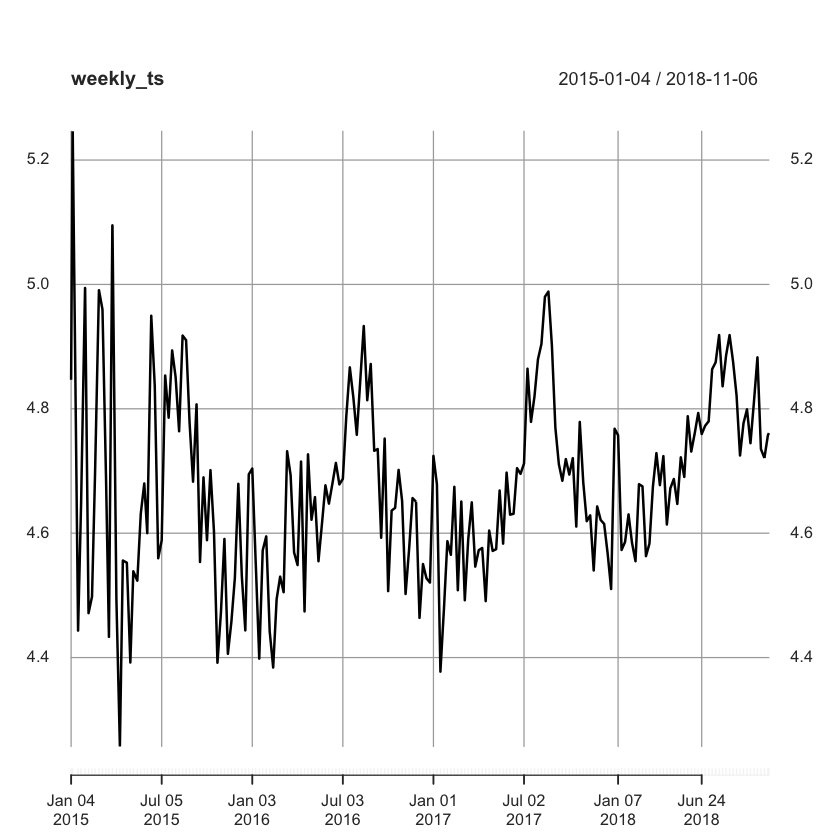

In [5]:
#looks like there could be some seasonality. Might make sense to aggregate data by week and see if there are trends. 
#group by week
daily_xts <- as.xts(meanprice$meanprice,order.by=as.Date(meanprice$date))
weekly_ts <- apply.weekly(daily_xts,mean)
tail(weekly_ts)

#plot weekly time series
plot.xts(weekly_ts)

In [6]:
# weekly_ts[1:nrow(weekly_ts),]

In [6]:
#clearly some seasonality. Prices tend to get much higher in the summers. Decompose ts 
#decompose.xts(weekly_ts)
test_ts <- ts(weekly_ts,frequency = 7)
stl(test_ts)

ERROR: Error in stl(test_ts): only univariate series are allowed


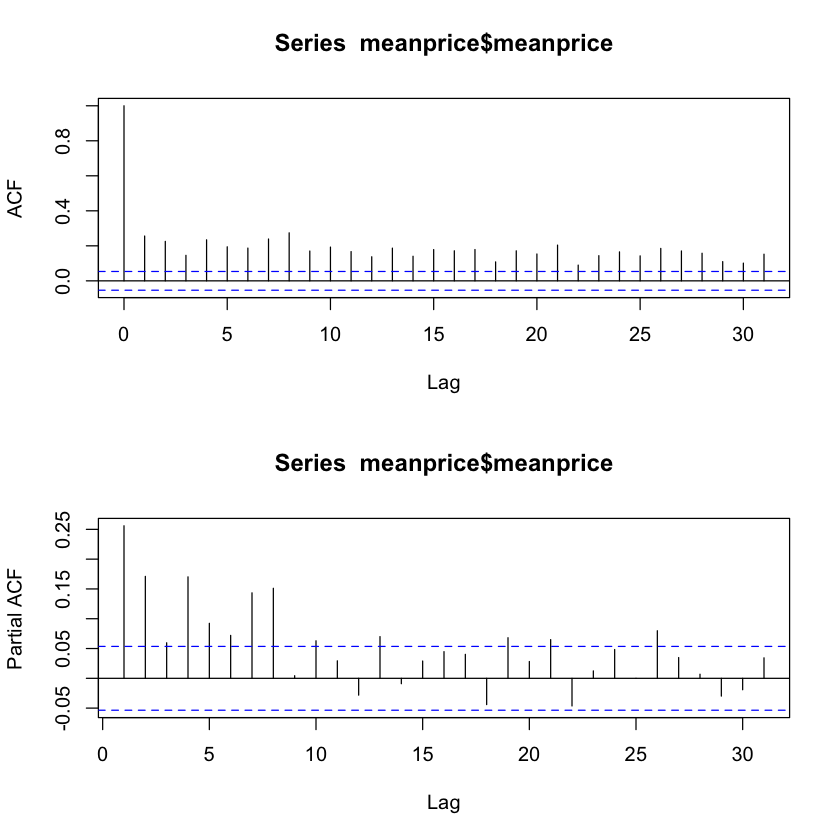

In [7]:
#head(meanprice)
par(mfrow=c(2,1))
acf(meanprice$meanprice)
pacf(meanprice$meanprice)

In [ ]:
#The lags for both acf and pacf are quite sinusodial. Could fit an simple ARMA model. 


# RMSE's

## Persistence

In [23]:
# weekly
weekly <- ts(as.numeric(weekly_ts), frequency=52)
n = length(weekly)
ntest = 20
ntrain = n-ntest

decompose.wk = decompose(weekly)
deseas.wk = weekly - decompose.wk$seasonal

train.wk = weekly[1:ntrain]
test.wk  = weekly[(ntrain+1):n]

length(train.wk)

mse = 0
fc = tail(train.wk, n=1)
zt = test.wk[1]
fcerror = zt-fc
mse = mse + fcerror^2

for (i in 2:ntest) {
    fc = test.wk[i-1]
    zt = test.wk[i]
    fcerror = zt-fc
    mse = mse + fcerror^2
}

rmse.persistence.wk = sqrt(mse/ntest)
paste("Weekly persistence RMSE: ", rmse.persistence.wk)

[1] 182

[1] "Weekly persistence RMSE:  0.0603039564124469"

## Average of Previous Observations

In [15]:
# Weekly
n = length(weekly)
ntrain = ceiling(n*.85)
ntest = n-ntrain

cumsum = sum(train.wk)
mse = 0
fc = cumsum/ntrain
zt = test.wk[1]
fcerror = zt-fc
mse = mse+fcerror^2

for (i in 2:ntest) {
    cumsum = cumsum+test.wk[i-1]
    fc = cumsum/(ntrain+i-1)
    zt = test.wk[i]
    fcerror = zt-fc
    mse = mse+fcerror^2
}

rmse.average.wk = sqrt(mse/ntest)
paste("Weekly average RMSE: ", rmse.average.wk)

[1] "Weekly average RMSE:  0.0968103361406652"

[1] "Daily average RMSE:  0.506958087271126"

# ARIMAX

## Preparing data for ARIMAX usage

In [9]:
#load data
vars <-c('date',
'price',
'latitude',
'longitude',
'cleaning_fee',
'review_scores_communication',
'review_scores_accuracy',
'calculated_host_listings_count',
'availability_365',
'review_scores_checkin',
'reviews_per_month',
'extra_people',
'guests_included',
'maximum_nights', 'last_review')


df2 <- df[,names(df) %in% vars]

#change to date time object
df2$last_review <- as.Date(df2$last_review, format="%Y-%m-%d")

#subset dataframe
df2 <- df2[df2$last_review > as.Date("2015-01-01"),]

#clean it up
df2 <- NaRV.omit(df2)
df2$cleaning_fee <- as.numeric(df2$cleaning_fee)
df2$extra_people <- as.numeric(df2$extra_people)
df2$price <- as.numeric(df2$price)
df3 <-  NaRV.omit(df2)
df3 <- as.xts(df3,order.by=as.Date(df3$last_review))
weeklydf <- apply.weekly(df3,mean)

Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”Warning message in FUN(newX[, i], ...):
“NAs int

In [13]:
colnames(weeklydf)

[1] "availability_365"               "calculated_host_listings_count"
 [3] "cleaning_fee"                   "extra_people"                  
 [5] "guests_included"                "last_review"                   
 [7] "latitude"                       "longitude"                     
 [9] "maximum_nights"                 "price"                         
[11] "review_scores_accuracy"         "review_scores_checkin"         
[13] "review_scores_communication"    "reviews_per_month"

## Building ARIMAX models

Warning message in arima(train.wk, order = c(2, 1, 1), seasonal = list(order = c(1, :
“possible convergence problem: optim gave code = 1”


Call:
arima(x = train.wk, order = c(2, 1, 1), seasonal = list(order = c(1, 0, 1), 
    period = 52), xreg = vtrain[, c(1:5, 7:8, 11:14)], method = "CSS")

Coefficients:
          ar1      ar2      ma1     sar1    sma1  availability_365
      -0.2642  -0.0435  -0.2567  -0.0813  0.3579             3e-04
s.e.   0.3460   0.1506   0.3489   0.0734  0.1024             3e-04
      calculated_host_listings_count  cleaning_fee  extra_people
                             -0.0220         4e-04       -0.0008
s.e.                          0.0164         7e-04        0.0012
      guests_included  latitude  longitude  review_scores_accuracy
               0.3378    9.3376    -1.2183                  0.1125
s.e.           0.0515    2.9682     1.1888                  0.0837
      review_scores_checkin  review_scores_communication  reviews_per_month
                    -0.2441                       0.2217            -0.0505
s.e.                 0.1953                       0.1054             0.0130

sigm

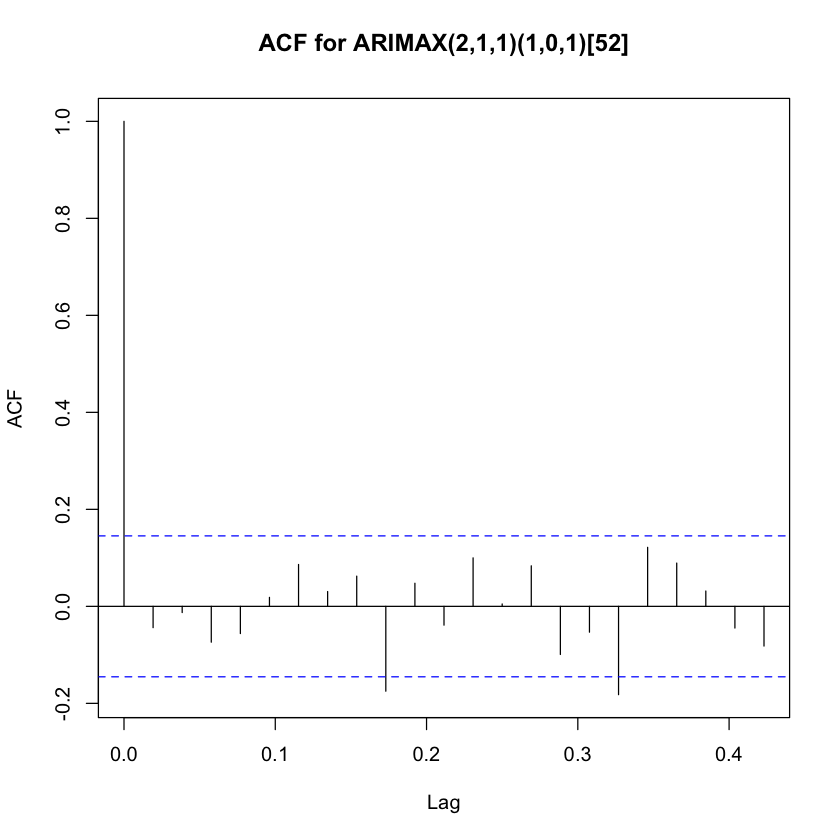

Series: train.wk 
Regression with ARIMA(2,0,2)(1,0,1)[52] errors 

Coefficients:
         ar1      ar2      ma1     ma2     sar1    sma1  availability_365
      1.5895  -0.6404  -1.2589  0.4733  -0.0306  0.3877             3e-04
s.e.  0.1068   0.1027   0.1407  0.1106   0.0217  0.0989             4e-04
      calculated_host_listings_count  cleaning_fee  extra_people
                             -0.0249         6e-04         0.000
s.e.                          0.0157         5e-04         0.001
      guests_included  latitude  longitude  review_scores_accuracy
               0.2728    1.7669     0.6714                  0.1500
s.e.           0.0430    2.3136     0.9258                  0.0737
      review_scores_checkin  review_scores_communication  reviews_per_month
                    -0.5122                       0.3399            -0.0416
s.e.                 0.1094                       0.0865             0.0126

sigma^2 estimated as 0.002945:  part log likelihood=248.96

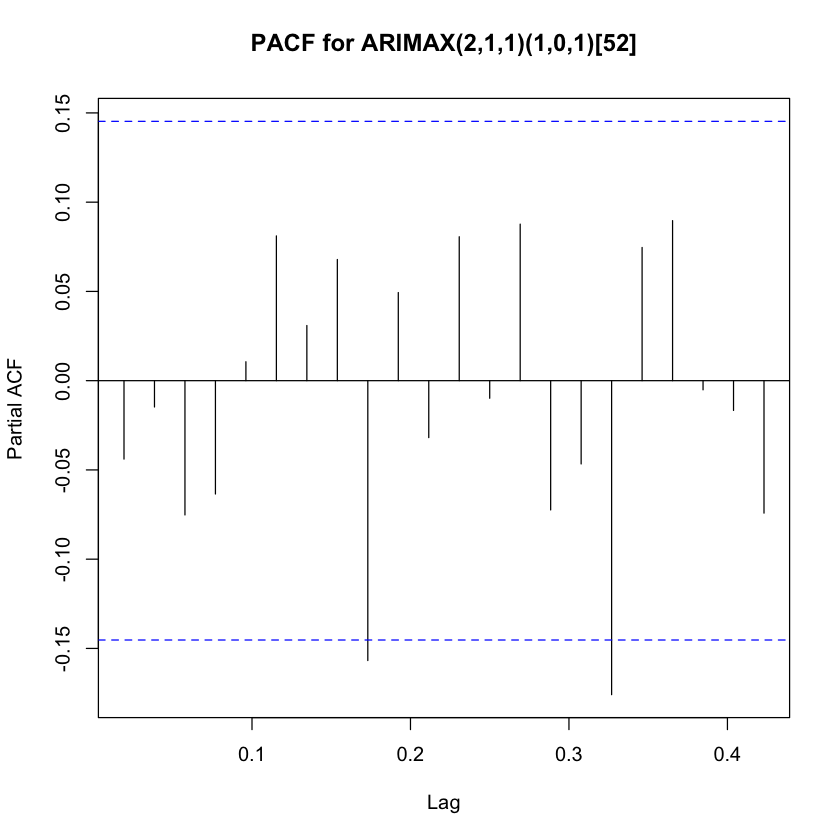

In [99]:
n = length(weekly)
ntest = 20
ntrain = n-ntest

train.wk = weekly[1:ntrain]
test.wk  = weekly[(ntrain+1):n]

train.wk = ts(train.wk, frequency = 52)
test.wk = ts(test.wk, frequency = 52)

vtrain = weeklydf[1:ntrain,]
vtest  = weeklydf[(ntrain+1):n,]

fitarimax = arima(train.wk, order=c(2,1,1),
                     seasonal=list(order=c(1,0,1), period=52),
                     xreg=vtrain[,c(1:5, 7:8, 11:14)], method="CSS")
fitarimax

acf(fitarimax$residuals, main="ACF for ARIMAX(2,1,1)(1,0,1)[52]")
acf(fitarimax$residuals, type = "partial", main="PACF for ARIMAX(2,1,1)(1,0,1)[52]")

p1 = predict(fitarimax, n.ahead=20, newxreg=vtest[,c(1:5, 7:8, 11:14)])

autoarima = auto.arima(train.wk, xreg = vtrain[,c(1:5, 7:8, 11:14)], method="CSS")
autoarima

Warning message in arima(train.wk, order = c(0, 1, 2), seasonal = list(order = c(1, :
“possible convergence problem: optim gave code = 1”Warning message in arima(train.wk, order = c(0, 1, 2), seasonal = list(order = c(1, :
“possible convergence problem: optim gave code = 1”Warning message in arima(train.wk, order = c(0, 1, 1), seasonal = list(order = c(1, :
“possible convergence problem: optim gave code = 1”Warning message in arima(train.wk, order = c(2, 1, 2), seasonal = list(order = c(1, :
“possible convergence problem: optim gave code = 1”Warning message in arima(train.wk, order = c(2, 1, 1), seasonal = list(order = c(1, :
“possible convergence problem: optim gave code = 1”

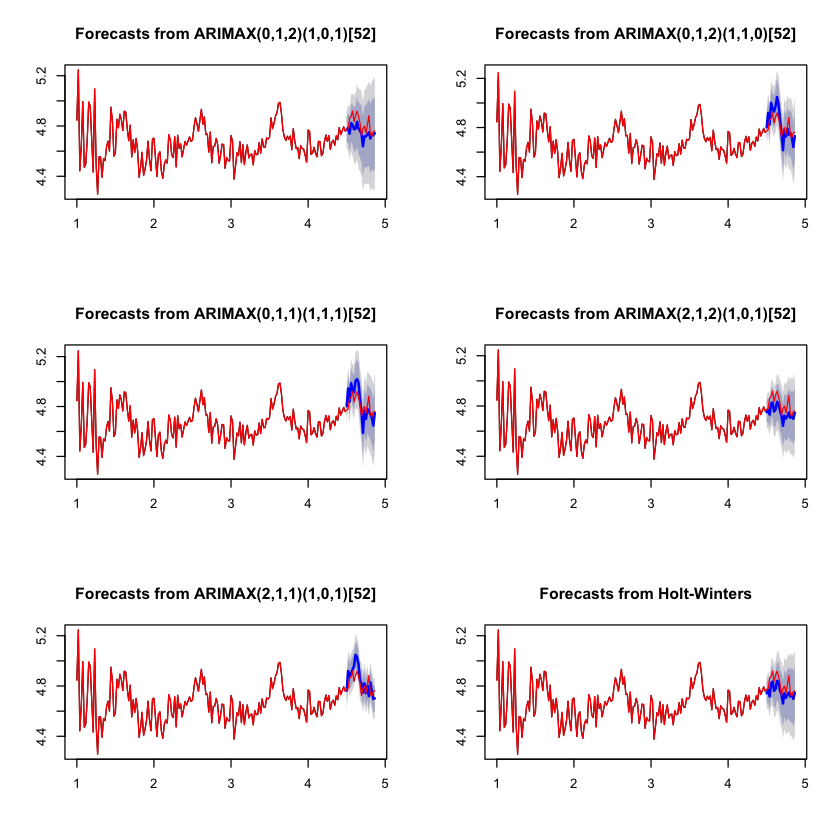

In [94]:
#train models on subset of data
train_fit3 <- arima(train.wk,order=c(0,1,2),seasonal = list(order=c(1,0,1),period=52), xreg=vtrain[,c(1:5, 7:8, 11:14)], method='CSS')
train_fit4 <- arima(train.wk,order=c(0,1,2),seasonal = list(order=c(1,1,0),period=52), xreg=vtrain[,c(1:5, 7:8, 11:14)], method='CSS')
train_fit5 <- arima(train.wk,order=c(0,1,1),seasonal = list(order=c(1,1,1),period=52), xreg=vtrain[,c(1:5, 7:8, 11:14)], method='CSS')
train_fit6 <- arima(train.wk,order=c(2,1,2),seasonal = list(order=c(1,0,1),period=52), xreg=vtrain[,c(1:5, 7:8, 11:14)], method='CSS')
train_fit7 <- arima(train.wk,order=c(2,1,1),seasonal = list(order=c(1,0,1),period=52), xreg=vtrain[,c(1:5, 7:8, 11:14)], method='CSS')
holtWint <- HoltWinters(train.wk,seasonal = 'additive')


#get forecats for holdout set
fcast_train3 <- forecast(train_fit3, h=20, xreg=vtest[,c(1:5, 7:8, 11:14)])
fcast_train4 <- forecast(train_fit4, h=20, xreg=vtest[,c(1:5, 7:8, 11:14)])
fcast_train5 <- forecast(train_fit5, h=20, xreg=vtest[,c(1:5, 7:8, 11:14)])
fcast_train6 <- forecast(train_fit6, h=20, xreg=vtest[,c(1:5, 7:8, 11:14)])
fcast_train7 <- forecast(train_fit7, h=20, xreg=vtest[,c(1:5, 7:8, 11:14)])
hwint_fcast <- forecast(holtWint, h=20,)

par(mfrow=c(3,2))
#plot forecast and holdout data
plot(fcast_train3, main="Forecasts from ARIMAX(0,1,2)(1,0,1)[52]")
lines(weekly,col='red')


plot(fcast_train4, main="Forecasts from ARIMAX(0,1,2)(1,1,0)[52]")
lines(weekly,col='red')

plot(fcast_train5, main="Forecasts from ARIMAX(0,1,1)(1,1,1)[52]")
lines(weekly,col='red')

plot(fcast_train6, main="Forecasts from ARIMAX(2,1,2)(1,0,1)[52]")
lines(weekly,col='red')

plot(hwint_fcast, main="Forecasts from ARIMAX(2,1,1)(1,0,1)[52]")
lines(weekly,col='red')

plot(fcast_train7, main="Forecasts from Holt-Winters")
lines(weekly,col='red')

In [101]:
fullfit.arimax = arima(weekly,order=c(2,1,1),seasonal = list(order=c(1,0,1),period=52), xreg=weeklydf[,c(1:5, 7:8, 11:14)], method='CSS')
forecast2021arimax = forecast(fullfit.arimax, h=104)

Warning message in arima(weekly, order = c(2, 1, 1), seasonal = list(order = c(1, :
“possible convergence problem: optim gave code = 1”

ERROR: Error in predict.Arima(object, n.ahead = h): 'xreg' and 'newxreg' have different numbers of columns


In [95]:
test.wk <- window(as.numeric(weekly), start=183)

accuracy(fcast_train3,test.wk);
accuracy(fcast_train4,test.wk);
accuracy(fcast_train5,test.wk);
accuracy(fcast_train6,test.wk);
accuracy(fcast_train7,test.wk);
accuracy(hwint_fcast,test.wk);

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.001543882,0.06465580,0.04581885,0.01958423,0.9853112,0.4166972,-0.141875415,NA
Test set,0.060321116,0.07678865,0.06326831,1.24407761,1.3063489,0.5753905,0.006629188,1.28143


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.001095481,0.04718488,0.02407344,0.01913484,0.5157877,0.2189346,-0.3230057,NA
Test set,-0.014298205,0.08678041,0.07027886,-0.28958595,1.4545751,0.6391475,0.2776677,1.444587


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.001086288,0.04848273,0.02480359,0.01920955,0.5322575,0.2255750,-0.2898707,NA
Test set,-0.011747540,0.08821814,0.06998557,-0.23629531,1.4502621,0.6364802,0.3033108,1.472373


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.003041826,0.05618551,0.03932785,0.05477038,0.8458278,0.3576651,-0.01001730,NA
Test set,0.064493585,0.07748137,0.06513301,1.33244473,1.3459894,0.5923489,-0.04415636,1.292351


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.002461151,0.05526769,0.03834612,0.04400703,0.8251922,0.3487369,-0.04391974,NA
Test set,0.059467046,0.07366096,0.06141800,1.22778449,1.2690976,0.5585630,-0.11754486,1.225994


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.01209961,0.08191240,0.05866524,0.2462716,1.259521,0.5335281,0.09714874,NA
Test set,-0.03107583,0.08330497,0.06437858,-0.6439191,1.334484,0.5854878,0.17338273,1.383647


In [65]:
nrow(vtest[,c(1:5, 7:8, 11:14)])

[1] 20

In [93]:
train_fit7


Call:
arima(x = train.wk, order = c(2, 1, 1), seasonal = list(order = c(1, 0, 1), 
    period = 52), xreg = vtrain[, c(1:5, 7:8, 11:14)], method = "CSS")

Coefficients:
          ar1      ar2      ma1     sar1    sma1  availability_365
      -0.2642  -0.0435  -0.2567  -0.0813  0.3579             3e-04
s.e.   0.3460   0.1506   0.3489   0.0734  0.1024             3e-04
      calculated_host_listings_count  cleaning_fee  extra_people
                             -0.0220         4e-04       -0.0008
s.e.                          0.0164         7e-04        0.0012
      guests_included  latitude  longitude  review_scores_accuracy
               0.3378    9.3376    -1.2183                  0.1125
s.e.           0.0515    2.9682     1.1888                  0.0837
      review_scores_checkin  review_scores_communication  reviews_per_month
                    -0.2441                       0.2217            -0.0505
s.e.                 0.1953                       0.1054             0.0130

sigm

In [ ]:
arimaACF = function(tseries, p, d, q) {
    modell = arima(tseries, order=c(p, d, q), method = "CSS")
    arima2 = ts(modell$residuals)
    tit = paste("ACF for (", p, ", ", d, ", ", q, ")")
    tit2 = paste("PACF for (", p, ", ", d, ", ", q, ")")
    
    par(mfrow=c(1,2))
    acf(arima2, main = tit)
    acf(arima2, type="partial", main = tit2)
}

arimaACF(deseas.wk, 3, 2, 0)
arimaACF(deseas.wk, 3, 1, 0)
arimaACF(deseas.wk, 3, 3, 0)